In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../../..'))) # access sibling directories
sys.path.append(os.path.abspath(os.path.join('../../../../BayesFlow_dev/BayesFlow/')))

from src.python.settings import summary_meta_validation, probability_meta_validation
from src.python.networks import HierarchicalInvariantNetwork, ModelProbabilityNetwork
from src.python.models import HierarchicalSdtMptSimulator, MainSimulator
from src.python.losses import softmax_loss
from src.python.helpers import n_clust_obs_f_f, get_repeated_predictions, get_preds_and_bfs
from src.python.visualization import perf_tester, plot_calibration_curve_repetition_uncertainty

import numpy as np
import bayesflow as bf
import pandas as pd
import tensorflow as tf
from functools import partial
from time import perf_counter
from datetime import datetime, timezone, timedelta
import matplotlib.pyplot as plt

c:\Users\lasse\projects\BayesFlow_dev\BayesFlow\bayesflow\trainers.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Set up simulators

In [3]:
# Sample size
n_clusters = 25
n_obs = 50

In [4]:
# Generative models
sdtmpt_model = HierarchicalSdtMptSimulator()

sdt_simulator = partial(sdtmpt_model.generate_batch, model_index=0, n_clusters=n_clusters, n_obs=n_obs, n_vars=2)
mpt_simulator = partial(sdtmpt_model.generate_batch, model_index=1, n_clusters=n_clusters, n_obs=n_obs, n_vars=2)
meta_model = bf.simulation.MultiGenerativeModel([sdt_simulator, mpt_simulator])

# Set up networks

In [5]:
summary_net = bf.summary_networks.HierarchicalNetwork([bf.networks.DeepSet(), bf.networks.DeepSet()])
probability_net = bf.inference_networks.PMPNetwork(num_models=2, dropout=False)
amortizer = bf.amortizers.AmortizedModelComparison(probability_net, summary_net)

In [6]:
# Training steps
epochs = 30 
iterations_per_epoch = 1000

# Optimizer
initial_lr = 0.00005 # smaller than default!
schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_lr, iterations_per_epoch * epochs, name="lr_decay"
)
optimizer = tf.keras.optimizers.Adam(schedule)

# Checkpoint path for loading pretrained network and saving the final network
checkpoint_path = 'C:/Users/lasse/OneDrive/Ph.D/Projekte/hierarchical_model_comparison/checkpoints/02_bridge_sampling_comparison/non_nested_models'

trainer = bf.trainers.Trainer(
    amortizer=amortizer, 
    generative_model=meta_model, 
    checkpoint_path=checkpoint_path
    )

INFO:root:Loaded loss history from C:/Users/lasse/OneDrive/Ph.D/Projekte/hierarchical_model_comparison/checkpoints/02_bridge_sampling_comparison/non_nested_models\history_30.pkl.
INFO:root:Networks loaded from C:/Users/lasse/OneDrive/Ph.D/Projekte/hierarchical_model_comparison/checkpoints/02_bridge_sampling_comparison/non_nested_models\ckpt-30
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


# Train

In [7]:
training_time_start = perf_counter()
losses = trainer.train_online(
    epochs=epochs, 
    iterations_per_epoch=iterations_per_epoch, 
    batch_size=32,
    optimizer=optimizer
    )
training_time_stop = perf_counter()

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/1000 [00:00<?, ?it/s]

# Validate

In [15]:
meta_model(5)['model_outputs']

[{'sim_data': array([[[[1., 1.],
           [1., 1.],
           [1., 1.],
           ...,
           [0., 0.],
           [0., 0.],
           [0., 0.]],
  
          [[1., 1.],
           [1., 1.],
           [1., 1.],
           ...,
           [0., 0.],
           [0., 0.],
           [0., 0.]],
  
          [[1., 0.],
           [1., 0.],
           [1., 0.],
           ...,
           [0., 1.],
           [0., 1.],
           [0., 1.]],
  
          ...,
  
          [[1., 0.],
           [1., 0.],
           [1., 0.],
           ...,
           [0., 1.],
           [0., 1.],
           [0., 1.]],
  
          [[1., 0.],
           [1., 0.],
           [1., 1.],
           ...,
           [0., 0.],
           [0., 1.],
           [0., 0.]],
  
          [[1., 1.],
           [1., 1.],
           [1., 1.],
           ...,
           [0., 1.],
           [0., 0.],
           [0., 0.]]],
  
  
         [[[1., 0.],
           [1., 1.],
           [1., 1.],
           ...,
           

In [11]:
trainer.configurator(meta_model(5))

{'summary_conditions': array([[[[1., 0.],
          [1., 1.],
          [1., 1.],
          ...,
          [0., 1.],
          [0., 1.],
          [0., 0.]],
 
         [[1., 1.],
          [1., 1.],
          [1., 0.],
          ...,
          [0., 0.],
          [0., 1.],
          [0., 0.]],
 
         [[1., 0.],
          [1., 1.],
          [1., 1.],
          ...,
          [0., 0.],
          [0., 1.],
          [0., 0.]],
 
         ...,
 
         [[1., 1.],
          [1., 1.],
          [1., 0.],
          ...,
          [0., 0.],
          [0., 1.],
          [0., 1.]],
 
         [[1., 1.],
          [1., 0.],
          [1., 0.],
          ...,
          [0., 1.],
          [0., 1.],
          [0., 1.]],
 
         [[1., 0.],
          [1., 1.],
          [1., 0.],
          ...,
          [0., 0.],
          [0., 1.],
          [0., 0.]]],
 
 
        [[[1., 1.],
          [1., 1.],
          [1., 1.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 1

ECE = 0.016


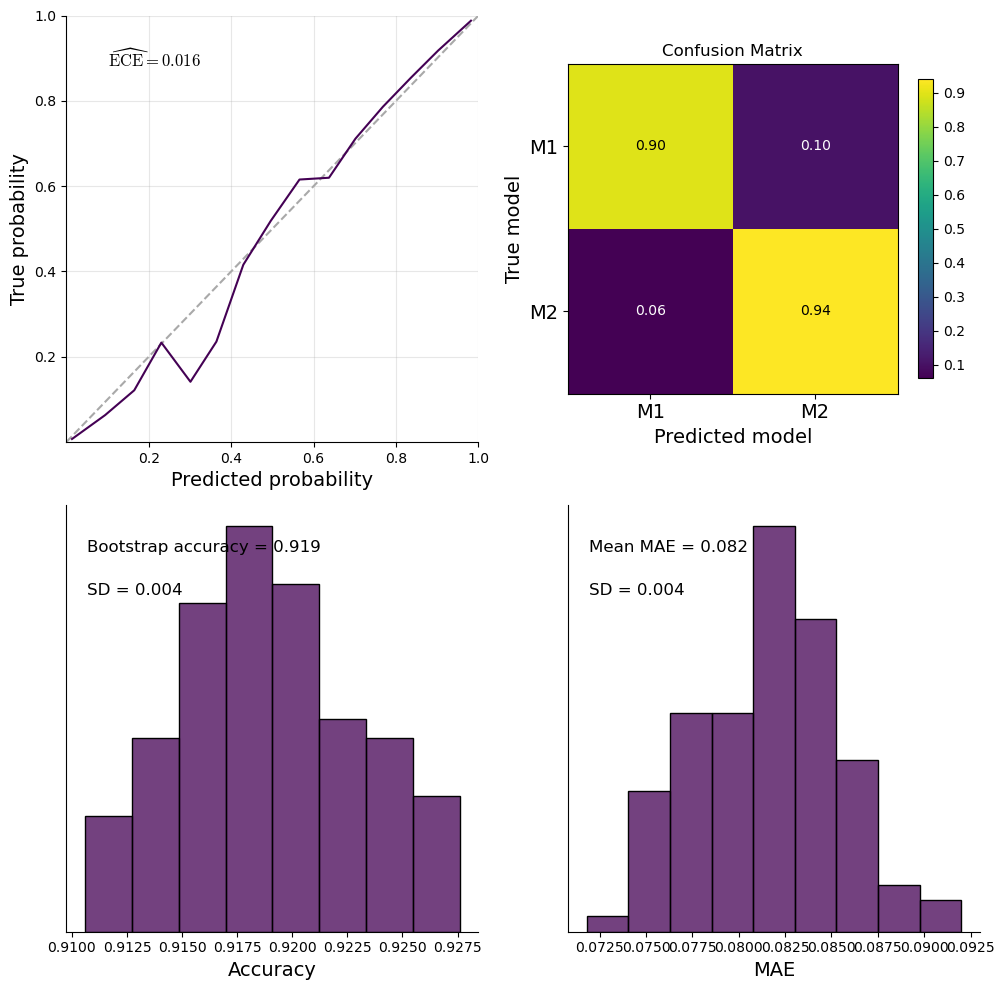

In [9]:
# Test performance 
val_data = trainer.configurator(meta_model(5000))
perf_tester(probability_net, summary_net, val_data, n_cal_bins=15)

In [ ]:
# Plot calibration with repetition uncertainty
n_repetitions = 25

fig, ax = plt.subplots(1, 1, figsize=(5,5))
m_true_r, m_soft_r = get_repeated_predictions(probability_net, summary_net, trainer, meta_model, 
                                              n_models=2, n_repetitions=n_repetitions)

plot_calibration_curve_repetition_uncertainty(m_true_r[:,:,1], m_soft_r[:,:,1], narrow_ci=[0.25, 0.75], wide_ci=[0.025, 0.975], n_bins=15, ax=ax, print_accuracy=True,
                                              xlabel=True, ylabel=True, title=None, show_ece=True, show_legend=True)

fig.savefig('calibration_SDTMPT.pdf', dpi=300, bbox_inches='tight')

Median ECE = 0.009618807224562554
Median accuracy = 0.9324


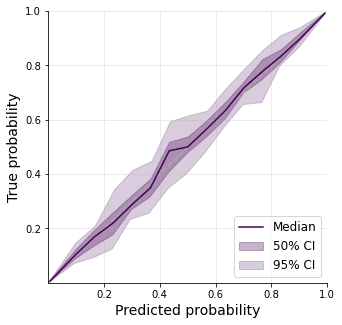

In [ ]:
# Plot calibration with repetition uncertainty
n_repetitions = 25

fig, ax = plt.subplots(1, 1, figsize=(5,5))
m_true_r, m_soft_r = get_repeated_predictions(probability_net, summary_net, 
                                              partial(simulator, batch_size=n_data_sets, n_obs=n_clust_obs_f_f(n_clusters, n_obs), n_vars=2), 
                                              n_models=2, n_repetitions=n_repetitions)

plot_calibration_curve_repetition_uncertainty(m_true_r[:,:,1], m_soft_r[:,:,1], narrow_ci=[0.25, 0.75], wide_ci=[0.025, 0.975], n_bins=15, ax=ax, print_accuracy=True,
                                              xlabel=True, ylabel=True, title=None, show_ece=True, show_legend=True)

fig.savefig('calibration_SDTMPT.pdf', dpi=300, bbox_inches='tight')

In [14]:
# Save training meta-information for bridge sampling comparison? 
# (so that network can be loaded from checkpoint)
save_training_vars = False

if save_training_vars:
    folder = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data', '02_bridge_sampling_comparison', 'non_nested_models')

    np.save(os.path.join(folder, 'training_time_start'), training_time_start, allow_pickle=True)
    np.save(os.path.join(folder, 'training_time_stop'), training_time_stop, allow_pickle=True)
    np.save(os.path.join(folder, 'losses'), losses, allow_pickle=True)

# Calculate Bayes factors for bridge sampling comparison

In [ ]:
# Import training meta-information? 
# (use if network was loaded from checkpoint)
import_training_vars = False

if import_training_vars:
    folder = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data', '01_calibration_validation', '03_variable')

    training_time_start = np.load(os.path.join(folder, 'training_time_start.npy'), allow_pickle=True)
    training_time_stop = np.load(os.path.join(folder, 'training_time_stop.npy'), allow_pickle=True)
    losses = np.load(os.path.join(folder, 'losses.npy'), allow_pickle=True).item()

In [15]:
# Import test data
val_folder = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data', '02_bridge_sampling_comparison','non_nested_models')
data_filename = "test_data.npy"
test_data = np.load(os.path.join(val_folder, data_filename), allow_pickle=True).item()

In [16]:
# Get NN predictions
comparison_results = get_preds_and_bfs(probability_net, summary_net, test_data, training_time_start, training_time_stop, losses)
comparison_results.head(5)

4/4 [==============================] - 0s 1ms/step


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
# Export results
local_timezone = datetime.now(timezone(timedelta(0))).astimezone().tzinfo
filename = pd.Timestamp.today(tz=local_timezone).strftime('%Y_%m_%d_BF_NN_softmax_30epochs')
comparison_folder = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data', '02_bridge_sampling_comparison','non_nested_models')

comparison_results.to_csv(os.path.join(comparison_folder, filename), index = False)